# Lesson - Machine Learning XIII: Kaggle Competitions

[Kaggle](https://www.kaggle.com/) is a site where people create algorithms and compete against machine learning practitioners around the world. Our algorithm wins the competition if it's the most accurate on a particular data set. Kaggle is a fun way to practice our machine learning skills.

In this lesson, we're going to learn how to compete in Kaggle competitions. In this introductory mission we'll learn how to:

- Approach a Kaggle competition
- Explore the competition data and learn about the competition topic
- Prepare data for machine learning
- Train a model
- Measure the accuracy of your model
- Prepare and make your first Kaggle submission.

**Dataset**

Kaggle has created a number of competitions.  One of the most popular of these competitions, and the one we'll be looking at, is about predicting which passengers survived the sinking of the Titanic. In this competition, we have a data set of different information about passengers onboard the Titanic, and we want to see if we can use that information to predict whether those people survived or not.
Each Kaggle competition has two key data files that we will work with - a training set and a testing set. The training set contains data we can use to train our model. It has a number of feature columns which contain various descriptive data, as well as a column of the target values we are trying to predict: in this case, `Survival`.

The testing set contains all of the same feature columns, but is missing the target value column. Additionally, the testing set usually has fewer observations (rows) than the training set. Once we have trained our model on the training set, we will use that model to make predictions on the data from the testing set, and submit those predictions to Kaggle.

In this competition, the two files are named `kaggle_test.csv` and `kaggle_train.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Setting pandas display options for large data
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

In [2]:
test = pd.read_csv("kaggle_test.csv")
test_shape = test.shape
train = pd.read_csv("kaggle_train.csv")
train_shape = train.shape
print(train_shape)
print(test_shape)

(891, 12)
(418, 11)


### Data Exploration
The files we read above are available on the data page for the [Titanic competition on Kaggle](https://www.kaggle.com/c/titanic/data). That page also has a data dictionary, which explains the various columns that make up the data set. Below are the descriptions contained in that data dictionary:

`PassengerID` - A column added by Kaggle to identify each row and make submissions easier

`Survived` - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)

`Pclass` - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)

`Sex` - The passenger's sex

`Age` - The passenger's age in years

`SibSp` - The number of siblings or spouses the passenger had aboard the Titanic

`Parch` - The number of parents or children the passenger had aboard the Titanic

`Ticket` - The passenger's ticket number

`Fare` - The fare the passenger paid

`Cabin` - The passenger's cabin number

`Embarked` - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

The data page on Kaggle has some additional notes about some of the columns.

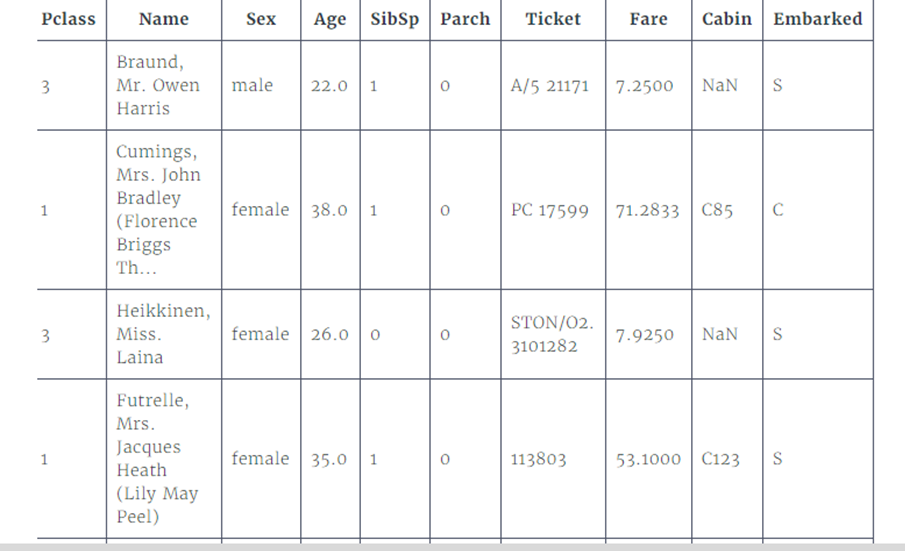


The type of machine learning we will be using will be binary classification. In any machine learning exercise, thinking about the topic you are predicting is very important. We call this step acquiring domain knowledge, and it's one of the most important determinants for success in machine learning. 

In this case, understanding the Titanic disaster and specifically what variables might affect the outcome of survival is important. In the case of Titanic disaster women and children were given preference to lifeboats. There was also a vast class disparity among the passengers.
This indicates that Age, Sex, and PClass may be good predictors of survival. We'll start by exploring Sex and Pclass by visualizing the data.

Because the Survived column contains 0 if the passenger did not survive and 1 if they did, we can segment our data by sex and calculate the mean of this column. We can use [`DataFrame.pivot_table()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot_table.html?highlight=pivot_tables) to easily do this:


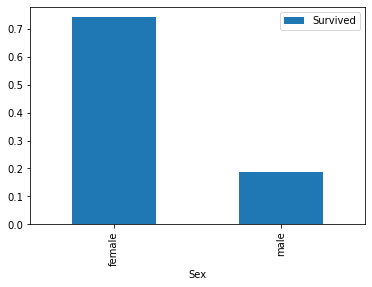

In [3]:
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

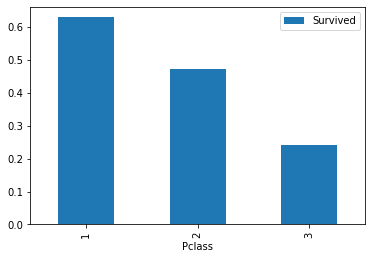

In [4]:
class_pivot = train.pivot_table(index="Pclass",values="Survived")
class_pivot.plot.bar()
plt.show()

### Age Column

We can see from above that females and 1st class passengers survived in much higher proportions than males and lower classes passengers did. Both these columns are categorical whereas the `Age` column is continuous. We will take a look at the `Age` column using `Series.describe()`. 

In [5]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

The `Age` column contains numbers ranging from `0.42` to `80.0` (if we look at Kaggle's data page, it informs us that Age is fractional if the passenger is less than one). The other thing to note here is that there are 714 values in this column, fewer than the 891 rows we discovered that the `train` data set had earlier which indicates we have some missing values. 

Above implies that the Age column needs to be treated slightly differently, as this is a continuous numerical column. One way to look at distribution of values in a continuous numerical set is to use histograms. We can create two histograms to compare visually those that survived vs those who died across different age ranges:

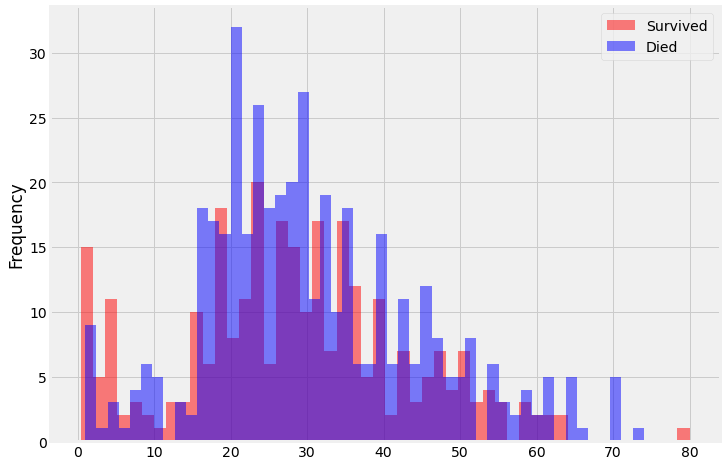

In [6]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]

fig = plt.figure(figsize=(12, 8))
plt.style.use('fivethirtyeight')
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

The relationship of Age with survival is a bit complicated. In order for this to be useful to our machine learning model, we can separate this continuous feature into a categorical feature by dividing it into ranges. We will use the [`pandas.cut()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) function for this. The `pandas.cut()` function has two required parameters - the column we wish to cut, and a list of numbers which define the boundaries of our cuts. We are also going to use the optional parameter labels, which takes a list of labels for the resultant bins. This will make it easier for us to understand our results.

Before we modify this column, we have to be aware of two things. Firstly, any change we make to the `train` data, we also need to apply to the `test` data, otherwise we will be unable to use our model to make predictions for our submissions. Secondly, we need to handle the missing values we observed above.

Below, we will:

- Create the cut_points and label_names lists to split the Age column into six categories:
`Missing`, from -1 to 0

`Infant`, from 0 to 5

`Child`, from 5 to 12

`Teenager`, from 12 to 18

`Young Adult`, from 18 to 35

`Adult`, from 35 to 60

`Senior`, from 60 to 100

- Apply the `process_age()` function on the train dataframe, assigning the result to train.
- Apply the `process_age()` function on the test dataframe, assigning the result to test.
- Use `DataFrame.pivot_table(`) to pivot the train dataframe by the `Age_categories` column.
- Use `DataFrame.plot.bar()` to plot the pivot table.

In [7]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

<Figure size 864x576 with 0 Axes>

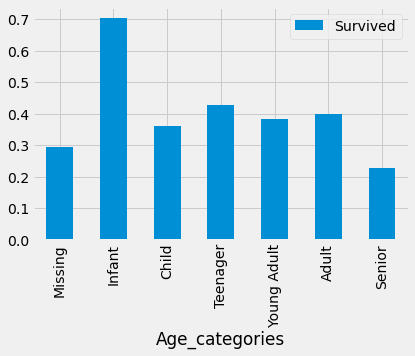

In [8]:
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)
fig = plt.figure(figsize=(12, 8))
plt.style.use('fivethirtyeight')
pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

### Preparing Data for Machine Learning

So far we have identified three columns that may be useful for predicting survival:

`Sex`

`Pclass`

`Age`, or more specifically our newly created `Age_categories`

Before we build our model, we need to prepare these columns for machine learning. Most machine learning algorithms can't understand text labels, so we have to convert our values into numbers.

Additionally, we need to be careful that we don't imply any numeric relationship where there isn't one. If we think of the values in the `Pclass` column, we know they are `1`, `2`, and `3`.

While the class of each passenger certainly has some sort of ordered relationship, the relationship between each class is not the same as the relationship between the numbers `1`, `2`, and `3`. For instance, class `2` isn't "worth" double what class `1` is, and class `3` isn't "worth" triple what class `1` is.

In order to remove this relationship, we can create dummy columns for each unique value in Pclass:

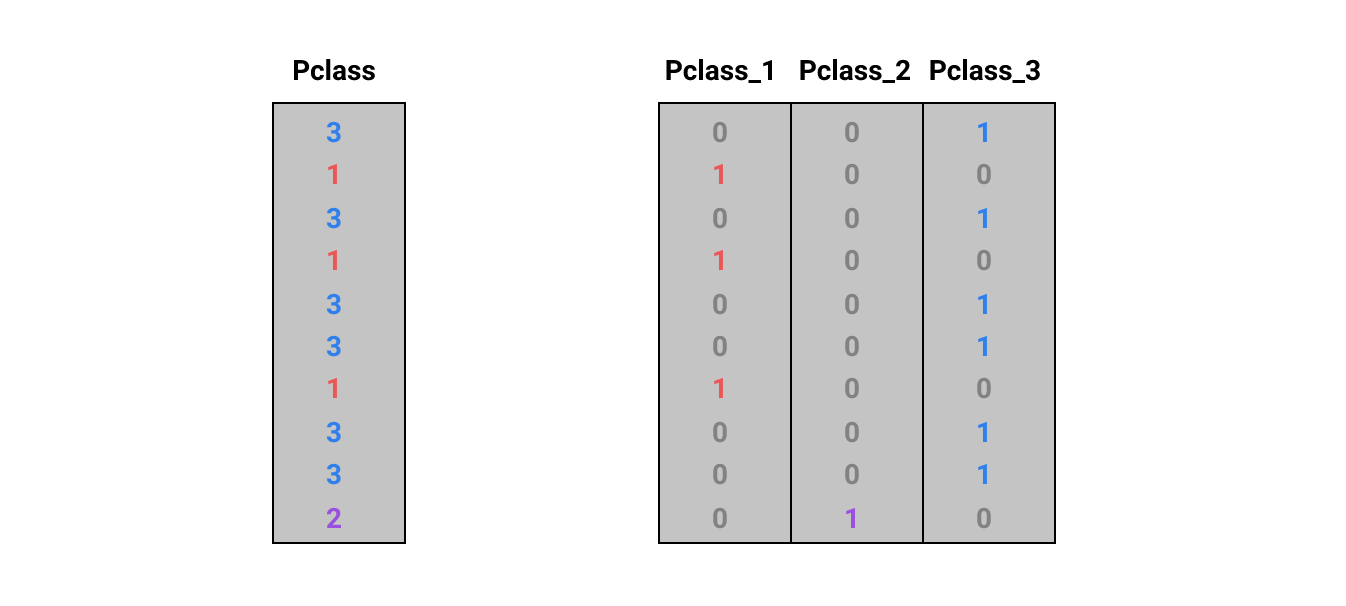

We can use the [`pandas.get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function, which will generate columns shown in the diagram above.

Below, we will:

- Write a function `create_dummies()` function to create dummy variables for the `Sex`, `Age` and `Pclass` columns in both the train and test dataframes.


In [9]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

print(train.columns)
print(test.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior'],
      dtype='object')


### Creating First Machine Learning Model

The first model we will use will be Logistic Regression, which is often the first model we will train when performing classification. We will be using the `scikit-learn` library as it has many tools that make performing machine learning easier. The scikit-learn workflow consists of four main steps:

- Instantiate (or create) the specific machine learning model we want to use
- Fit the model to the training data
- Use the model to make predictions
- Evaluate the accuracy of the predictions

Each model in scikit-learn is implemented as a separate class and the first step is to identify the class we want to create an instance of. In our case, we want to use the `LogisticRegression` class.

Below, we will:

- Instantiate a `LogisticRegression` object called `lr`.
- Use `LogisticRegression.fit()` to fit the model on the train dataset using:
- The columns contained in columns as the first (`X`) parameter or features.
- The Survived column as the second (`y`) parameter or target.

In [10]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])

LogisticRegression()

### Splitting Training Data

Next step is to find out how accurate our model is, and to do that, we'll have to make some predictions.

We do have a `test` dataframe that we could use to make predictions. We could make predictions on that data set, but because it doesn't have the `Survived` column we would have to submit it to Kaggle to find out our accuracy. We could also fit and predict on our train dataframe, however if we do this there is a high likelihood that our model will overfit, which means it will perform well because we're testing on the same data we've trained on, but then perform much worse on new, unseen data.

We could also fit and predict on our `train` dataframe, however if we do this there is a high likelihood that our model will overfit, which means it will perform well because we're testing on the same data we've trained on, but then perform much worse on new, unseen data.

Instead we can split our train dataframe into two:

- One part to train our model on (often 80% of the observations)
- One part to make predictions with and test our model (often 20% of the observations)

The convention in machine learning is to call these two parts `train` and `test`. This can become confusing, since we already have our `test` dataframe that we will eventually use to make predictions to submit to Kaggle. To avoid confusion, from here on, we're going to call this Kaggle 'test' data `holdout` data, which is the technical name given to this type of data used for final predictions.

The scikit-learn library has a handy [`model_selection.train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function that we can use to split our data. train_test_split() accepts two parameters, X and y, which contain all the data we want to train and test on, and returns four objects: `train_X`, `train_y`, `test_X`, `test_y`:
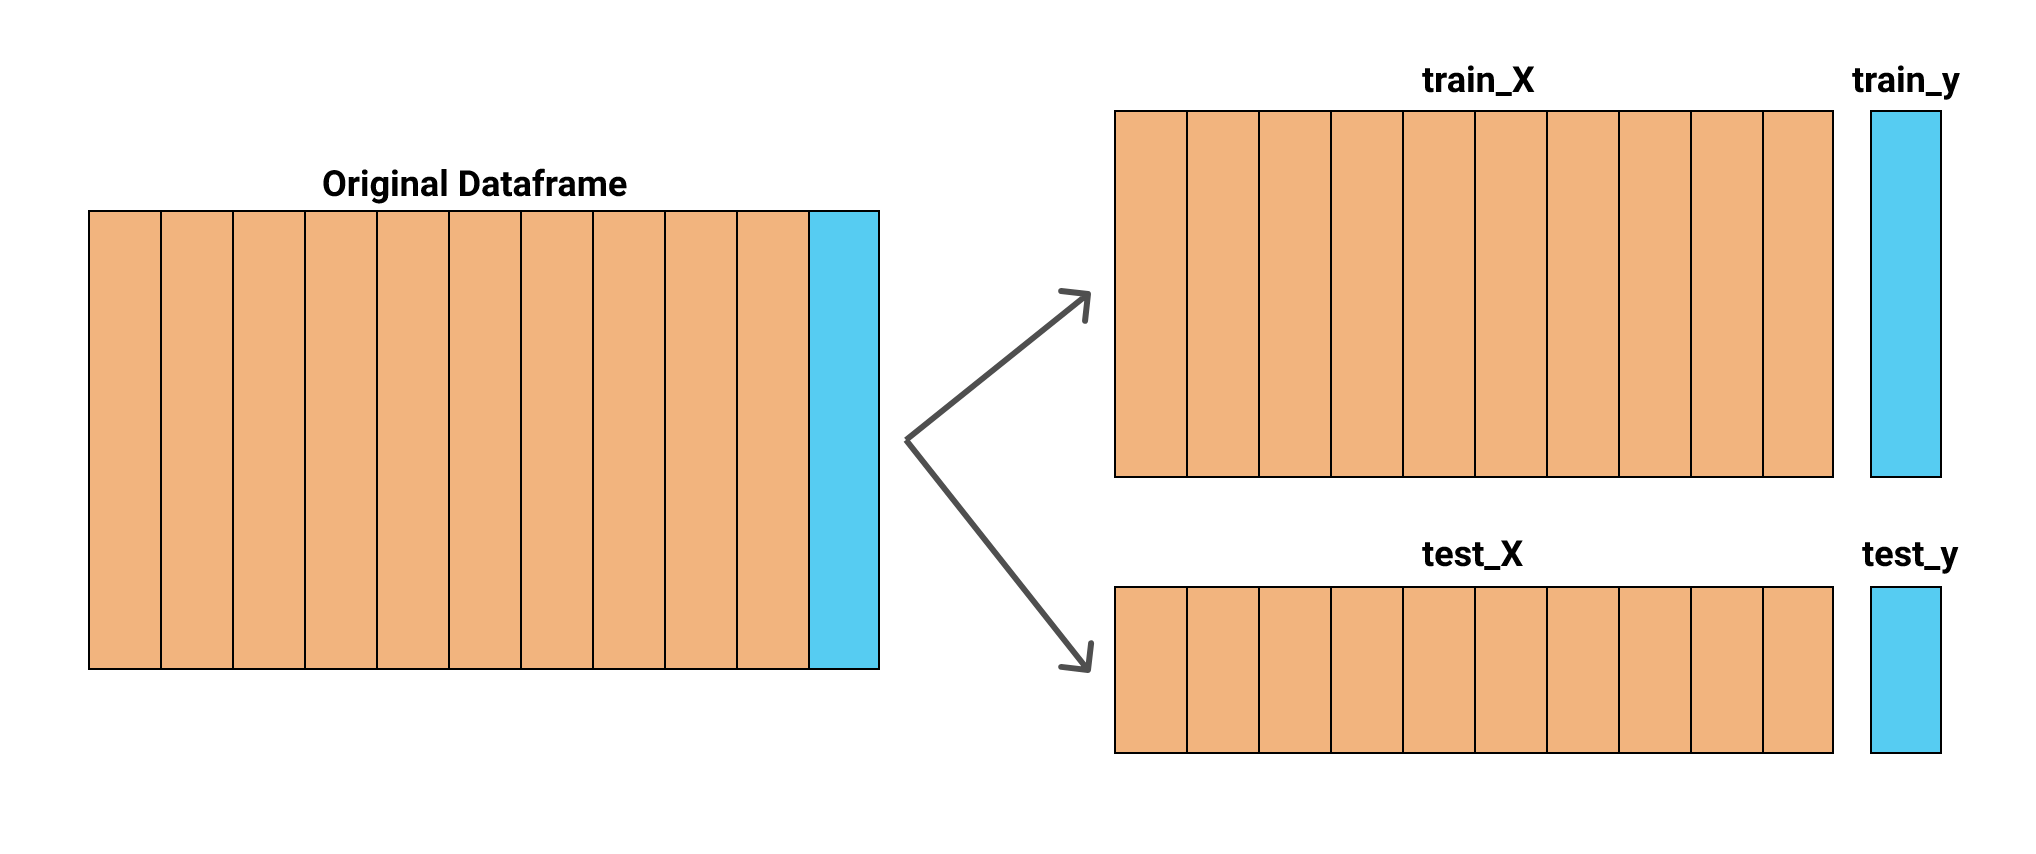

There are two other parameters we will use: `test_size`, which lets us control what proportions our data are split into, and `random_state`. The `train_test_split()` function randomizes observations before dividing them, and setting a random seed means that our results will be reproducible, which is important if we are collaborating, or need to produce consistent results each time.

We will plit the `train` dataframe using the following parameters:
- `test_size` of `0.2`.
- `random_state` of `0`.



In [11]:
holdout = test # from now on we will refer to this
               # dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.20,random_state=0)

### Making Predictions and Mesuring Accuracy

we can fit our model again on our training set, and then use that model to make predictions on our test set.

Once we have fit our model, we can use the [`LogisticRegression.predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict) method to make predictions. The `predict()` method takes a single parameter `X`, a two dimensional array of features for the observations we wish to predict. `X` must have the exact same features as the array we used to fit our model. The method returns single dimensional array of predictions.

There are a number of ways to measure the accuracy of machine learning models, but when competing in Kaggle competitions you want to make sure you use the same method that Kaggle uses to calculate accuracy for that specific competition. In this case, the [evaluation section for the Titanic competition](https://www.kaggle.com/c/titanic#evaluation) on Kaggle tells us that our score calculated as "the percentage of passengers correctly predicted". This is by far the most common form of accuracy for binary classification. scikit-learn has a handy function we can use to calculate accuracy: `metrics.accuracy_score()`. The function accepts two parameters, `y_true` and `y_pred`, which are the actual values and our predicted values respectively, and returns our accuracy score.

In [12]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y, predictions)
accuracy

0.8100558659217877

### Using Cross Validation for more Accurate Error Measurement

Our model has an accuracy score of 81.0% when tested against our 20% test set. Given that this data set is quite small, there is a good chance that our model is overfitting, and will not perform as well on totally unseen data.

To give us a better understanding of the real performance of our model, we can use cross validation to train and test our model on different splits of our data, and then average the accuracy scores.

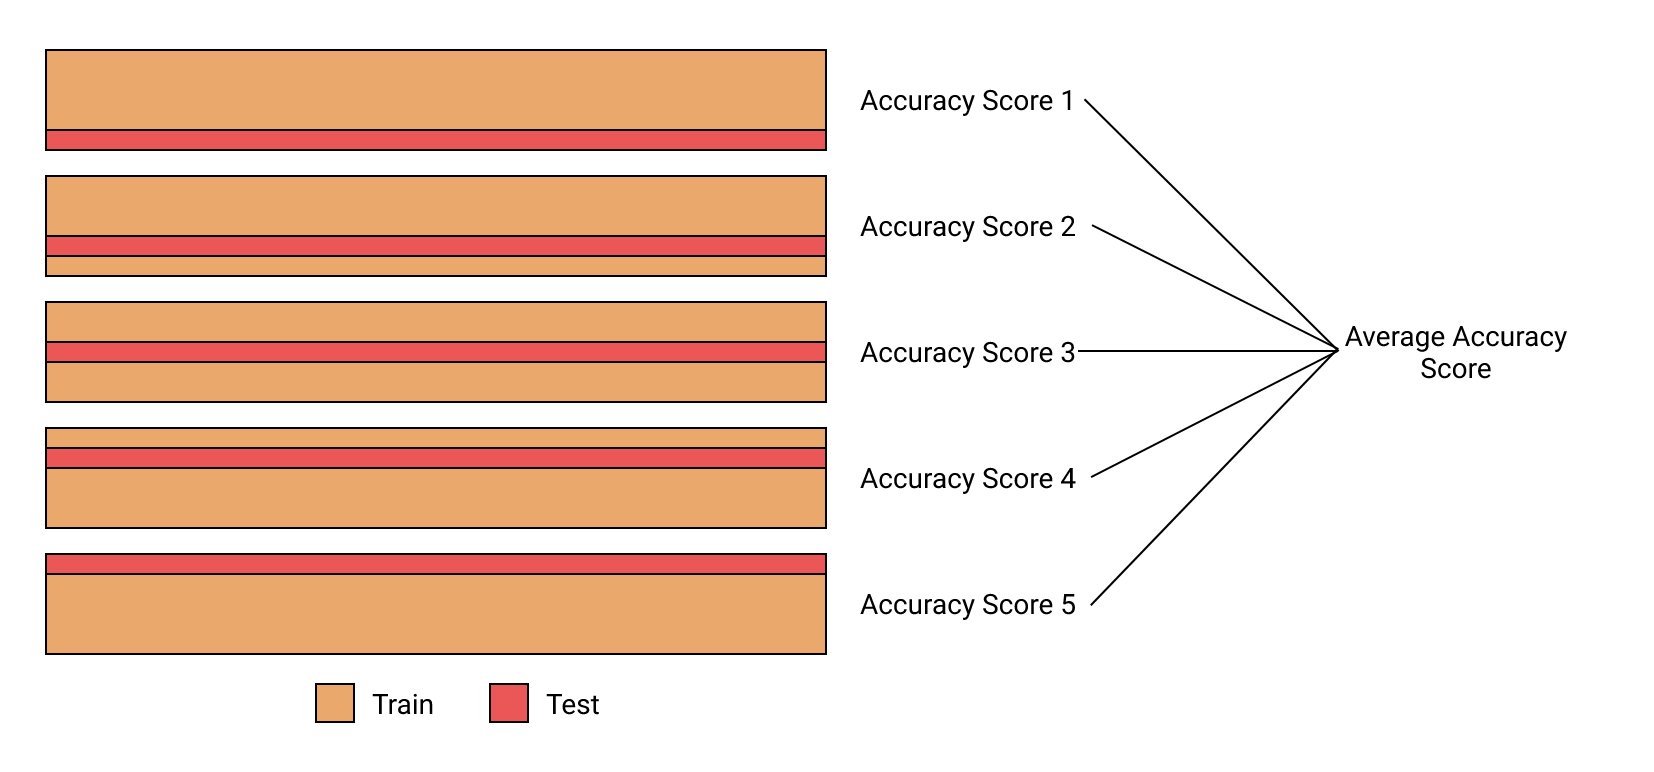

The most common form of cross validation, and the one we will be using, is called k-fold cross validation. 'Fold' refers to each different iteration that we train our model on, and 'k' just refers to the number of folds. In the diagram above, we have illustrated k-fold validation where k is 5. We will use scikit-learn's [`model_selection.cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) function to automate the process. The basic syntax for cross_val_score() is:

```
cross_val_score(estimator, X, y, cv=None)
```

`estimator` is a scikit-learn estimator object, like the LogisticRegression() objects we have been creating.

`X` is all features from our data set.

`y` is the target variables.

`cv` specifies the number of folds.

`cross_val_score()` function can use a variety of cross validation techniques and scoring types, but it defaults to k-fold validation and accuracy scores for our input types.

Below, we will instantiate new LogisticRegression() object `lr` and a RandomClassifier() object `rf` and use the datasets `all_X` and `all_y` with `cv` set at 10 folds and then calculate mean of all `scores`.

In [13]:
# Using a logistic regression estimator
from sklearn.model_selection import cross_val_score
import numpy as np
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.8        0.82022472 0.76404494 0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80898876]
0.8024719101123596


In [14]:
# Using a random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 500, max_depth = 3)
scores = cross_val_score(rf, all_X, all_y, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.83333333 0.83146067 0.76404494 0.87640449 0.82022472 0.7752809
 0.78651685 0.75280899 0.83146067 0.79775281]
0.8069288389513108


### Making Predictions on Unseen Data

We have used both logistic regression and random forest classifiers and both give approximately similar results though thee random forest if more likely to be overfitting as we have set the max depth to 4. But we will make predictions with both on the `holdout` set. 

Below, we will:

- Instantiate new LogisticRegression() object, lr, and new RandomForest() object
- Use the `fit()` method to train the model `lr` using all of the Kaggle training data: `all_X` and `all_y`.
- Make predictions using the holdout data and assign the result to `holdout_predictions_lr` and `holdout_predictions_rf`

In [15]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions_lr = lr.predict(holdout[columns])

In [16]:
rf = RandomForestClassifier(n_estimators = 200, max_depth = 4)
rf.fit(all_X,all_y)
holdout_predictions_rf = rf.predict(holdout[columns])

### Creating Submission Files

Each Kaggle competition can have slightly different requirements for the submission file. Here's what is specified on the Titanic competition evaluation page:

*You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

The file should have exactly 2 columns:

`PassengerId` (sorted in any order)

`Survived` (contains our binary predictions: 1 for survived, 0 for deceased)*

We will need to create two new dataframes that contains the `holdout_predictions_lr` and `holdout_predictions_rf` we created above and the `PassengerId column` from the `holdout` dataframe. We don't need to worry about matching the data up, as both of these remain in their original order.

To do this, we can pass a dictionary to the `pandas.DataFrame()` function.

In [17]:
# lr submisssion
# holdout_ids = holdout["PassengerId"]
# submission_df_lr = {"PassengerId": holdout_ids,
#                  "Survived": holdout_predictions_lr}
# submission_lr = pd.DataFrame(submission_df_lr)

# submission_lr.to_csv("submission_lr.csv",index=False)

In [18]:
# rf submission
# holdout_ids = holdout["PassengerId"]
# submission_df_rf = {"PassengerId": holdout_ids,
#                  "Survived": holdout_predictions_rf}
# submission_rf = pd.DataFrame(submission_df_rf)

# submission_rf.to_csv("submission_rf.csv",index=False)

### Submitting to Kaggle

We can start our submission to Kaggle by clicking the blue 'Submit Predictions' button on the [competition page](https://www.kaggle.com/c/titanic/submit). We are getting an accuracy of 76.315% on both classifiers as opposed to over 80% on training data which means that we are somewhat overfitting.  

## Sec-II: Feature Selection, Preparation and Engineering

Our two submissions to Kaggle received an accuracy score of 76.315%. While this is a good start, there is definitely room for improvement. There are two main areas we can focus on to boost the accuracy of our predictions:

- Improving the features we train our model on
- Improving the model itself

We will now focus on working with the features used in our model. We'll start by looking at **feature selection**. Feature selection is important because it helps to exclude features which are not good predictors, or features that are closely related to each other. Both of these will cause our model to be less accurate, particularly on previously unseen data.

The diagram below illustrates this. The red dots represent the data we are trying to predict, and each of the blue lines represents a different model.

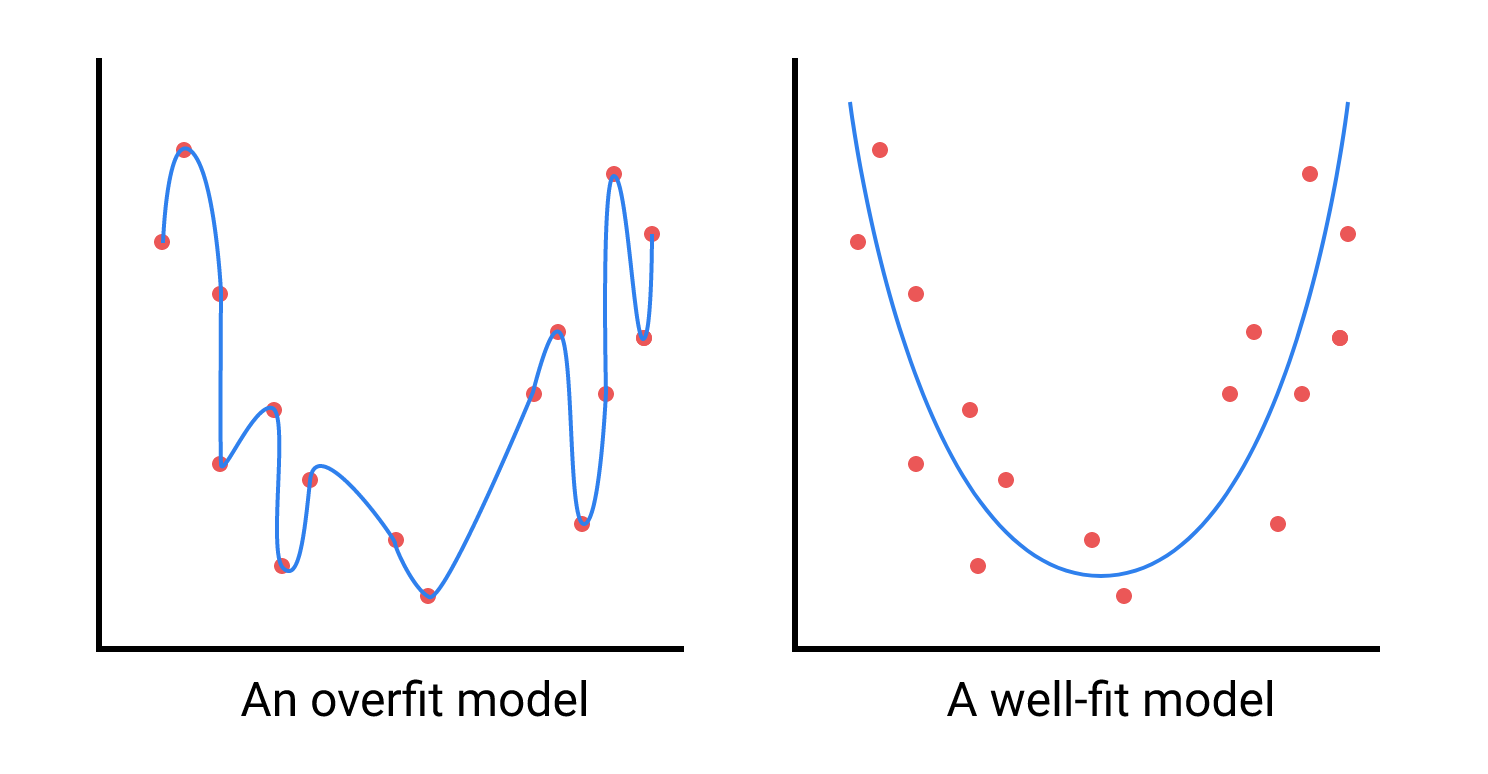

The model on the left is **overfitting**, which means the model represents the training data too closely, and is unlikely to predict well on unseen data, like the holdout data for our Kaggle competition. We have already trained our model using data about the `age`, `sex` and `class` of the passengers on the Titanic. We will now be using the functions we created earlier i.e. `process_age` and `create_dummies` to add more columns. Any modifications we make to our training data (`train.csv`) we also have to make to our holdout data (`test.csv`).

In [19]:
print(train.columns)
print(holdout.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior'],
      dtype='object')


We can see there are a number of features we haven't yet utilized. We can ignore `PassengerId`, since this is just a column Kaggle have added to identify each passenger and calculate scores. We can also ignore `Survived`, as this is what we're predicting, as well as the three columns we've already used. Here is a list of the remaining columns (with a brief description), followed by 10 randomly selected passengers from and their data from those columns, so we can refamiliarize ourselves with the data.

`SibSp` - The number of siblings or spouses the passenger had aboard the Titanic

`Parch` - The number of parents or children the passenger had aboard the Titanic

`Ticket` - The passenger's ticket number

`Fare` - The fair the passenger paid

`Cabin` - The passengers cabin number

`Embarked` - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

In [20]:
new_cols = ['Name','SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
print(train[new_cols].sample(10, random_state = 1))

                                                  Name  SibSp  Parch  \
862  Swift, Mrs. Frederick Joel (Margaret Welles Ba...      0      0   
223                               Nenkoff, Mr. Christo      0      0   
84                                 Ilett, Miss. Bertha      0      0   
680                                Peters, Miss. Katie      0      0   
535                             Hart, Miss. Eva Miriam      0      2   
623                        Hansen, Mr. Henry Damsgaard      0      0   
148           Navratil, Mr. Michel ("Louis M Hoffman")      0      2   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)      1      0   
34                             Meyer, Mr. Edgar Joseph      1      0   
241                     Murphy, Miss. Katherine "Kate"      1      0   

           Ticket     Fare Cabin Embarked  
862         17466  25.9292   D17        S  
223        349234   7.8958   NaN        S  
84     SO/C 14885  10.5000   NaN        S  
680        330935   8.1375   Na

At first glance, both the `Name` and `Ticket` columns look to be unique to each passenger. We will come back to these columns later, but for now we'll focus on the other columns.

We can use the `Dataframe.describe()` method to give us some more information on the values within each remaining column.

In [21]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all',percentiles=[]))

             SibSp       Parch        Fare Cabin Embarked
count   891.000000  891.000000  891.000000   204      889
unique         NaN         NaN         NaN   147        3
top            NaN         NaN         NaN    G6        S
freq           NaN         NaN         NaN     4      644
mean      0.523008    0.381594   32.204208   NaN      NaN
std       1.102743    0.806057   49.693429   NaN      NaN
min       0.000000    0.000000    0.000000   NaN      NaN
50%       0.000000    0.000000   14.454200   NaN      NaN
max       8.000000    6.000000  512.329200   NaN      NaN


Of these, `SibSp`, `Parch` and `Fare` look to be standard numeric columns with no missing values. `Cabin` has values for only `204` of the `891` rows, and even then most of the values are unique, so for now we will leave this column also. `Embarked` looks to be a standard categorical column with `3` unique values, much like `PClass` was, except that there are two missing values. We can easily fill these two missing values with the most common value, `"S"` which occurs `644` times.

Looking at our numeric columns, we can see a big difference between the range of each. SibSp has values between 0-8, Parch between 0-6, and Fare is on a dramatically different scale, with values ranging from 0-512. In order to make sure these values are equally weighted within our model, we'll need to rescale the data. 
Rescaling simply stretches or shrinks the data as needed to be on the same scale, in our case between 0 and 1.
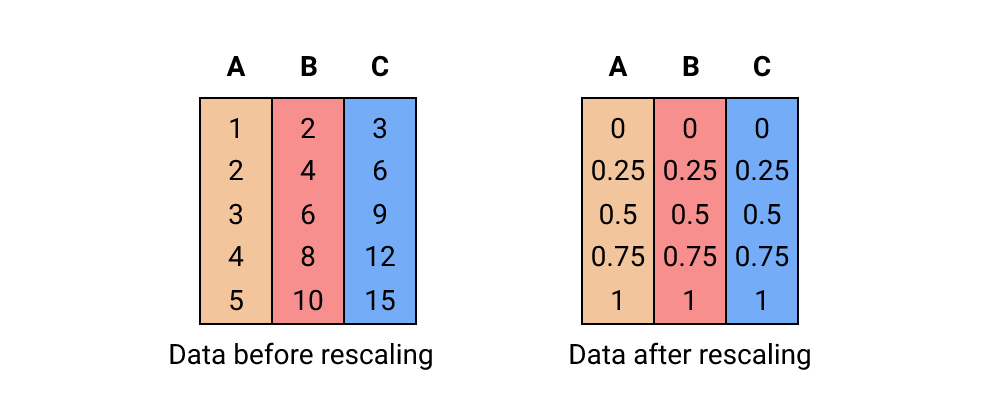

In the diagram above, the three columns have different minimum and maximum values before rescaling.

After rescaling, the values in each feature has been compressed or stretched so that they are all on the same scale - they have the same minimum and maximum, and the relationship between each point is still the same relative other points in that feature. We can now easily see that the data represented in each column is identical.

Within scikit-learn, the `preprocessing.minmax_scale()` function allows us to quickly and easily rescale our data. 
Below, We will:

For both the `train` and `holdout` dataframes:
- Use the `Series.fillna()` method to replace any missing values in the `Embarked` column with `"S"`

- Use our `create_dummies()` function to create dummy columns for the `Embarked` column.

- Use `minmax_scale()` to rescale the `SibSp`, `Parch`, and `Fare` columns, assigning the results back to new columns `SibSp_scaled`, `Parch_scaled`. and `Fare_scaled` respectively.

In [22]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())
columns = ["SibSp","Parch","Fare"]

train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

train = create_dummies(train,"Embarked")
holdout = create_dummies(holdout,"Embarked")

for col in columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

### Determining most Relevant Features

In order to select the best-performing features, we need a way to measure which of our features are relevant to our outcome - in this case, the survival of each passenger. One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature.

The scikit-learn [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class has an attribute in which coefficients are stored after the model is fit, `LogisticRegression.coef_`. We first need to train our model, after which we can access this attribute.

The `coef()` method returns a NumPy array of coefficients, in the same order as the features that were used to fit the model. To make these easier to interpret, we can convert the coefficients to a pandas series, adding the column names as the index.

Below, we will:

- Instantiate a `LogisticRegression()` object.

- Fit the LogisticRegression object using the columns from the list columns from the train dataframe and the target column Survived.

- Use the `coef_` attribute to retrieve the coefficients of the features, and assign the results to coefficients.

- Create a series object using coefficients, with the feature column names as the index and assign it to `feature_importance`.

- Use the `Series.plot.barh()` method to plot the `feature_importance` series.

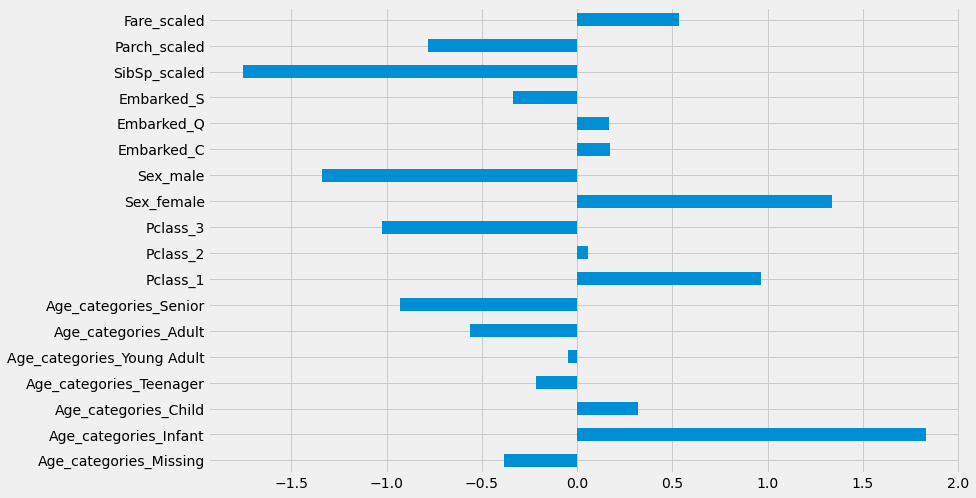

In [23]:
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']
lr = LogisticRegression()
lr.fit(train[columns],train['Survived'])

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=train[columns].columns)

fig = plt.figure(figsize=(12, 8))
plt.style.use('fivethirtyeight')
feature_importance.plot.barh()
plt.show()

### Training a Model using Relevant Features

The plot we generated in the last screen showed a range of both positive and negative values. Whether the value is positive or negative isn't as important in this case, relative to the magnitude of the value. If you think about it, this makes sense. A feature that indicates strongly whether a passenger died is just as useful as a feature that indicates strongly that a passenger survived, given they are mutually exclusive outcomes.

To make things easier to interpret, we'll alter the plot to show all positive values, and have sorted the bars in order of size:

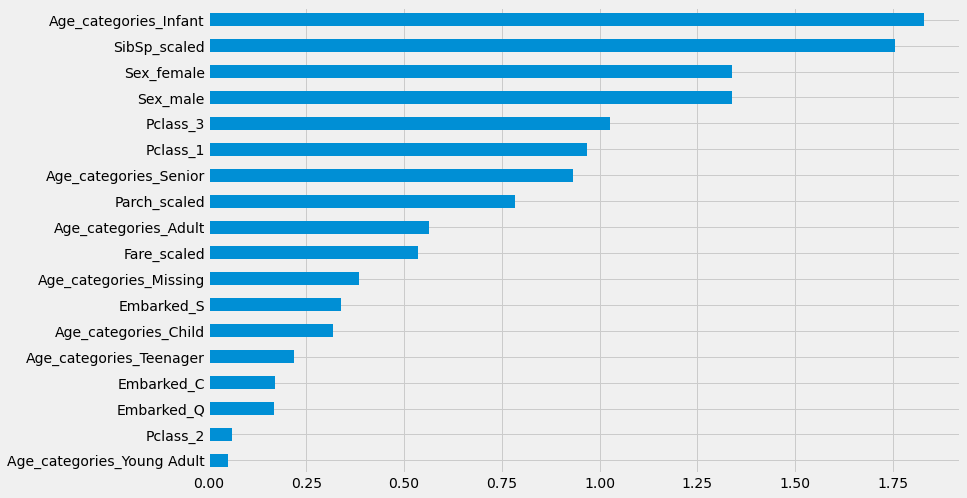

In [24]:
ordered_feature_importance = feature_importance.abs().sort_values()

fig = plt.figure(figsize=(12, 8))
plt.style.use('fivethirtyeight')
ordered_feature_importance.plot.barh()
plt.show()

Below, we will:

- Instantiate a `LogisticRegression()` object.

- Use the `model_selection.cross_val_score()` function and assign the returned object to scores, using:

- The columns specified in columns and all rows from the train dataframe.

- A `cv` parameter of `10`.

- Calculate the mean of the cross validation scores and assign the results to `accuracy`.

- Use the `print()` function to display the variable accuracy.

In [25]:
from sklearn.model_selection import cross_val_score

columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']
all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
print(scores)
print(accuracy)

[0.82222222 0.83146067 0.78651685 0.86516854 0.83146067 0.78651685
 0.79775281 0.76404494 0.84269663 0.82022472]
0.8148064918851435


In [26]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 4)
scores = cross_val_score(rf, all_X, all_y, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.81111111 0.84269663 0.76404494 0.87640449 0.84269663 0.79775281
 0.80898876 0.78651685 0.85393258 0.82022472]
0.8204369538077403


### Resubmitting Results to Kaggle

The cross validation score of 81.48% and 82.1% are marginally higher than the cross validation score for the model we created earlier, which had a score of around 80.2%. We will now again train two models i.e. a LinearRegression() classifier and a RandomForest() classifier based on these 8 features and resubmit results to Kaggle to determine accuracy. 

In [27]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions_lr = lr.predict(holdout[columns])

In [28]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']
rf = RandomForestClassifier(n_estimators = 500, max_depth = 4)
rf.fit(all_X,all_y)
holdout_predictions_rf = rf.predict(holdout[columns])

In [29]:
# # lr submisssion
# holdout_ids = holdout["PassengerId"]
# submission_df_lr = {"PassengerId": holdout_ids,
#                  "Survived": holdout_predictions_lr}
# submission_lr = pd.DataFrame(submission_df_lr)

# submission_lr.to_csv("submission_lr_2.csv",index=False)

In [30]:
# # rf submission
# holdout_ids = holdout["PassengerId"]
# submission_df_rf = {"PassengerId": holdout_ids,
#                  "Survived": holdout_predictions_rf}
# submission_rf = pd.DataFrame(submission_df_rf)

# submission_rf.to_csv("submission_rf_2.csv",index=False)

### Engineering a New Feature Binning

Last submission to Kaggle improved the accuracy to 77.0751 and improved the posiiton on the leaderboard by 8000 places to 5474 out of 16680. A lot of the gains in accuracy in machine learning come from **Feature Engineering**. Feature engineering is the practice of creating new features from existing data. One common way to engineer a feature is using a technique called **binning**. Binning is when you take a continuous feature, like the fare a passenger paid for their ticket, and separate it out into several ranges (or 'bins'), turning it into a categorical variable. This can be useful when there are patterns in the data that are non-linear and we're using a linear model (like logistic regression). We actually used binning earlier when we dealt with the `Age` column.

Let's look at histograms of the `Fare` column for passengers who died and survived, and see if there are patterns that we can use when creating our bins.

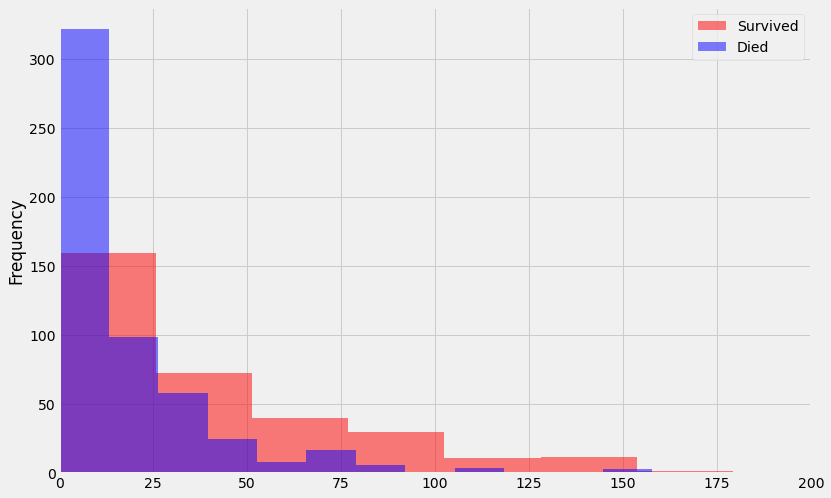

In [31]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]

fig = plt.figure(figsize=(12, 8))
plt.style.use('fivethirtyeight')
survived["Fare"].plot.hist(alpha=0.5,color='red',bins=20)
died["Fare"].plot.hist(alpha=0.5,color='blue',bins=20)
plt.xlim(0, 200)
plt.legend(['Survived','Died'])
plt.show()

Looking at the values, it looks like we can separate the feature into four bins to capture some patterns from the data:

`0-25`

`25-50`

`50-100`

`100+`

we can use the [`pandas.cut()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) which allows for non-uniform width bins to create our bins.

Below, we will:

- create a function `process_fare()` that uses the pandas `cut()` method to create bins for the `Fare` column and assign the results to a new column called `Fare_categories`.

- We have already dealt with missing values in the Fare column, so we won't need to use `fillna()`.

- Use the `process_fare()` function on both the `train` and holdout dataframes, creating the four 'bins':
`0-25`, for values between 0 and 25.

`25-50`, for values between 25 and 50.

`50-100`, for values between 50 and 100.

`100+`, for values between 100 and 1000.

- Use the `create_dummies()` function we created earlier on both the `train` and `holdout` dataframes to create dummy columns based on our new fare bins.

In [32]:
def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-25","25-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

### Engineering Features from Text Columns

Another way to engineer features is by extracting data from text columns. Earlier, we decided that the Name and Cabin columns weren't useful by themselves, but what if there is some data there we could extract? Let's take a look at a random sample of rows from those two columns

In [33]:
train[['Name', 'Cabin']].sample(10, random_state = 1)

,Name,Cabin
862,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",D17
223,"Nenkoff, Mr. Christo",NaN
84,"Ilett, Miss. Bertha",NaN
680,"Peters, Miss. Katie",NaN
535,"Hart, Miss. Eva Miriam",NaN
623,"Hansen, Mr. Henry Damsgaard",NaN
148,"Navratil, Mr. Michel (""Louis M Hoffman"")",F2
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123
34,"Meyer, Mr. Edgar Joseph",NaN
241,"Murphy, Miss. Katherine ""Kate""",NaN


While in isolation the cabin number of each passenger will be reasonably unique to each, we can see that the format of the cabin numbers is one letter followed by two or three numbers. It seems like the letter is representative of the type of cabin, which could be useful data for us. We can use the pandas `Series.str` accessor and then subset the first character using brackets:

In [34]:
print(train.head()["Cabin"].str[0])

0    NaN
1      C
2    NaN
3      C
4    NaN
Name: Cabin, dtype: object


Looking at the Name column, There is a title like 'Mr' or 'Mrs' within each, as well as some less common titles, like the 'Countess' from the final row of our table above. By spending some time researching the different titles, we can categorize these into six types:

`Mr`

`Mrs`

`Master`

`Miss`

`Officer`

`Royalty`

We can use the [`Series.str.extract` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html) and a regular expression to extract the title from each name and then use the [`Series.map()` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html?highlight=map#pandas.Series.map) and a predefined dictionary to simplify the titles.

Below, we will:

- Use `extract()`, `map()` and the dictionary `titles` to categorize the titles for the `train` and `holdout` dataframe and assign the results to a new column `Title`.

- For both the `train` and `holdout` dataframes:
 - Use the `str()` accessor to extract the first letter from the Cabin column and assign the result to a new column Cabin_type.
 - Use the `fillna()` method to fill any missing values in `Cabin_type` with `"Unknown"`

- For the newly created columns `Title` and `Cabin_type`, use `create_dummies()` to create dummy columns for both the `train` and `holdout` dataframes.

In [35]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

###  Finding Correlated Features

We now have 34 possible feature columns we can use to train our model. One thing to be aware of as we start to add more features is a concept called **collinearity**. Collinearity occurs where more than one feature contains data that are similar. The effect of collinearity is that our model will overfit - we may get great results on our test data set, but then the model performs worse on unseen data (like the `holdout` set).

One easy way to understand collinearity is with a simple binary variable like the `Sex` column in our dataset. Every passenger in our data is categorized as either male or female, so 'not male' is exactly the same as 'female'.

As a result, when we created our two dummy columns from the categorical `Sex` column, we've actually created two columns with identical data in them. This will happen whenever we create dummy columns, and is called the [dummy variable trap](https://www.algosome.com/articles/dummy-variable-trap-regression.html). The easy solution is to choose one column to drop any time we make dummy columns.

Collinearity can happen in other places, too. A common way to spot collinearity is to plot correlations between each pair of variables in a heatmap. An example of this style of plot is below:

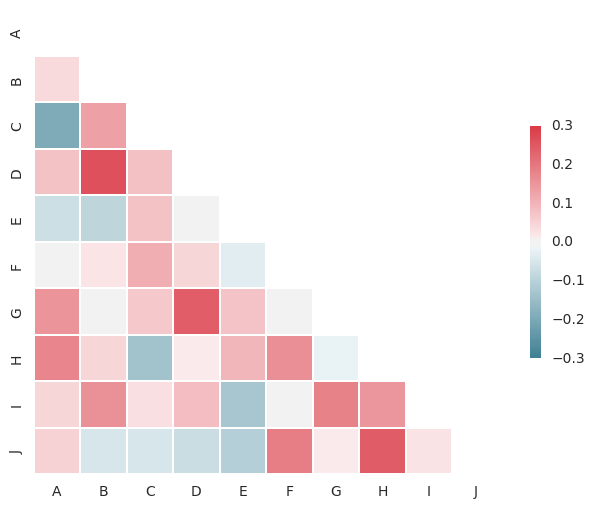

The darker squares, whether the darker red or darker blue, indicate pairs of columns that have higher correlation and may lead to collinearity. The easiest way to produce this plot is using the [`DataFrame.corr()` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to produce a correlation matrix, and then use the Seaborn library's [`seaborn.heatmap()` function](https://seaborn.pydata.org/generated/seaborn.heatmap.html) to plot the values.

Below, we will:

Write and use the `plot_correlation_heatmap()` function to produce a heatmap for the train dataframe, using only the features in the list `columns`

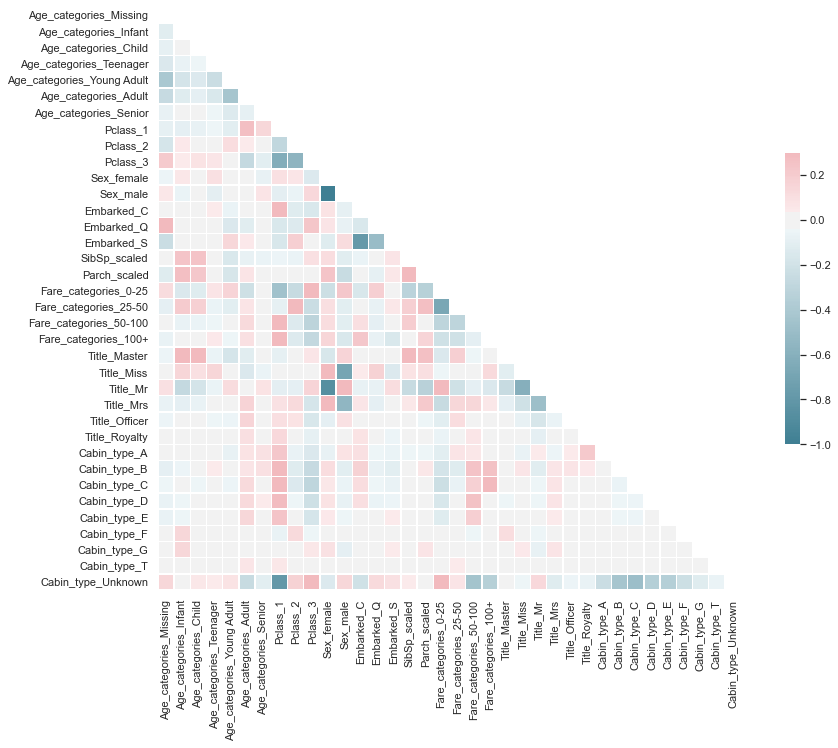

In [36]:
# We have already all the required libraries already

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(14, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-25',
       'Fare_categories_25-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']
plot_correlation_heatmap(train[columns])

### Feature Selection using RFEVC

We can see that there is a high correlation between Sex_female/Sex_male and Title_Miss/Title_Mr/Title_Mrs. We will remove the columns Sex_female and Sex_male since the title data may be more nuanced.

Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:

`Pclass_2`

`Age_categories_Teenager`

`Fare_categories_25-50`

`Title_Master`

`Cabin_type_A`

We manually used the logit coefficients to select the most relevant features. An alternate method is to use one of scikit-learn's inbuilt feature selection classes. We will be using the [`feature_selection.RFECV` class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) which performs **recursive feature elimination with cross-validation**.

The `RFECV` class starts by training a model using all of our features and scores it using cross validation. It then uses the logit coefficients to eliminate the least important feature, and trains and scores a new model. At the end, the class looks at all the scores, and selects the set of features which scored highest.

Like the `LogisticRegression` class, `RFECV` must first be instantiated and then fit. The first parameter when creating the `RFECV` object must be an estimator, and we need to use the `cv` parameter to specific the number of folds for cross-validation.

```
from sklearn.feature_selection import RFECV
lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)
```
Once the `RFECV` object has been fit, we can use the `RFECV.support_` attribute to access a boolean mask of `True` and `False` values which we can use to generate a list of optimized columns:
```
optimized_columns = all_X.columns[selector.support_]
```
Below, we will:

- Instantiate a `LogisticRegression()` object, lr and a `RandomForestClassifier()` object, rf.
- Instantiate a `RFECV()` object `selector` using the newly created `lr` and `rf` objects and `cv=10` as parameters.
- Use the `fit()` method to fit `selector` using a`ll_X` and `all_y`
- Use the `support_` attribute selector to subset `all_X.columns`, and assign the result to `optimized_columns`.

In [37]:
# Using logistic regression classifier
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-25', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]
lr = LogisticRegression()
selector_lr = RFECV(lr,cv=10)
selector_lr.fit(all_X,all_y)

optimized_columns_lr = all_X.columns[selector_lr.support_]
optimized_columns_lr

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')

In [38]:
# Using random forest classifier
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-25', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]
rf = RandomForestClassifier(n_estimators = 200, max_depth = 4)
selector_rf = RFECV(rf,cv=10)
selector_rf.fit(all_X,all_y)

optimized_columns_rf = all_X.columns[selector_rf.support_]
optimized_columns_rf

Index(['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-25', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_Unknown'],
      dtype='object')

In [39]:
len(optimized_columns_rf)

28

### Training Models using Optimized Columns
`RFEVC` has yielded different results i.e. 4 columns for logisitc regression estimator and 28 columns for random forest estimator.

Below, we will:

- Instantiate `LogisticRegression()` and `RandomForestClassifer()` objects.
- Use the `model_selection.cross_val_score()` function and assign the results to `scores_lr` and `scores_rf`, using:
 `all_X` and `all_y`.
- A `cv` parameter of `10`.
- Calculate the mean of the cross validation scores and assign the results to `accuracy_lr` and `accuracy_rf`

In [41]:
# Logistic Regression Classifier

all_X_lr = train[optimized_columns_lr]
all_y = train["Survived"]

lr = LogisticRegression()
scores_lr = cross_val_score(lr, all_X_lr, all_y, cv=10)
accuracy_lr = scores_lr.mean()
print(scores_lr)
print(accuracy_lr)

[0.83333333 0.84269663 0.76404494 0.87640449 0.83146067 0.80898876
 0.80898876 0.78651685 0.84269663 0.83146067]
0.8226591760299625


In [42]:
# Random Forest Classifier

all_X_rf = train[optimized_columns_rf]
all_y = train["Survived"]

rf = RandomForestClassifier(n_estimators = 200, max_depth = 4)
scores_rf = cross_val_score(rf, all_X_rf, all_y, cv=10)
accuracy_rf = scores_rf.mean()
print(scores_rf)
print(accuracy_rf)

[0.82222222 0.82022472 0.76404494 0.88764045 0.85393258 0.83146067
 0.82022472 0.79775281 0.83146067 0.83146067]
0.8260424469413232


### Resubmitting Models to Kaggle

Both models above have produced near identical results despite different features being used for classification. Now, we will train respective columns on the `holdout` set, save submission files and see what score we get from Kaggle.


In [43]:
# # For logistic regression classifier

# lr = LogisticRegression()
# lr.fit(all_X_lr,all_y)
# holdout_predictions_lr = lr.predict(holdout[optimized_columns_lr])

# holdout_ids_lr = holdout["PassengerId"]
# submission_df_lr = {"PassengerId": holdout_ids_lr,
#                  "Survived": holdout_predictions_lr}
# submission_lr = pd.DataFrame(submission_df_lr)

# submission_lr.to_csv("submission_lr_3.csv",index=False)

In [44]:
# # For rndom forest classifier

# rf = RandomForestClassifier(n_estimators = 200, max_depth = 4)
# rf.fit(all_X_rf,all_y)
# holdout_predictions_rf = rf.predict(holdout[optimized_columns_rf])

# holdout_ids_rf = holdout["PassengerId"]
# submission_df_rf = {"PassengerId": holdout_ids_rf,
#                  "Survived": holdout_predictions_rf}
# submission_rf = pd.DataFrame(submission_df_rf)

# submission_rf.to_csv("submission_rf_4.csv",index=False)

### Kaggle Submission Results

We have achieved an accuracy of 77.511% with the logistic regression classifier and 77.990 with the random forest classifier on Kaggle. The position has improved to 4488 on the leaderboard. 

By preparing, engineering and selecting features, we have increased our accuracy by 2.4%. When working in Kaggle competitions, we should spend a lot of time experimenting with features, particularly feature engineering.

Here are some ideas we can use to work with features for this competition:

- Use `SibSp` and `Parch` to explore total relatives onboard.
- Create combinations of multiple columns, for instance `Pclass + Sex`.
- See if we can extract useful data out of the `Ticket` column.
- Try different combinations of features to see if we can identify features that overfit less than others.

## Sec-III: Model Selection and Tuning

The process of selecting the algorithm which gives the best predictions for our data is called model selection. We have already used two different models based on different estimators i.e. a logistic regression classifier and a random forest classifier. Now, we will again experiment with the random forest model and try to tune it with different hyperparameters. We will also use the K-nearest neighbours models to try and improve accuracy. 

The features we created earlier (not subjected to RFECV) are stored as CSV files, `train_modified.csv` and `holdout_modified.csv`, first we will read them in.

In [45]:
train = pd.read_csv('train_modified.csv')
holdout = pd.read_csv('holdout_modified.csv')

In [49]:
(len(train.columns))
train.columns

Index(['Survived', 'PassengerId', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled',
       'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T',
       'Cabin_type_Unknown'],
      dtype='object')

### Training a Baseline Model

We're going to train our models using all the columns in the train dataframe. This will cause a small amount of overfitting due to collinearity, but having more features will allow us to more thoroughly compare algorithms. First though, we're going to train a logistic regression model like earlier for comparison purposes. We'll use cross validation to get a baseline score.


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

all_X = train.drop(['Survived','PassengerId'],axis=1)
all_y = train['Survived']
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy_lr = scores.mean()
print(scores)
print(accuracy_lr)

[0.76666667 0.84269663 0.7752809  0.87640449 0.83146067 0.80898876
 0.82022472 0.82022472 0.85393258 0.85393258]
0.8249812734082397


### Training a Model using K-Nearest Neighbors

The logistic regression baseline model from the previous screen scored 82.4%. The logistic regression algorithm works by calculating linear relationships between the features and the target variable and using those to make predictions. Let's look at an algorithm that makes predictions using a different method.

The **k-nearest neighbors** algorithm finds the observations in our training set most similar to the observation in our test set, and uses the average outcome of those 'neighbor' observations to make a prediction. The 'k' is the number of neighbor observations used to make the prediction.

The plots below shows three simple k-nearest neighbors models where there are two features shown on each axis, and two outcomes, red and green.

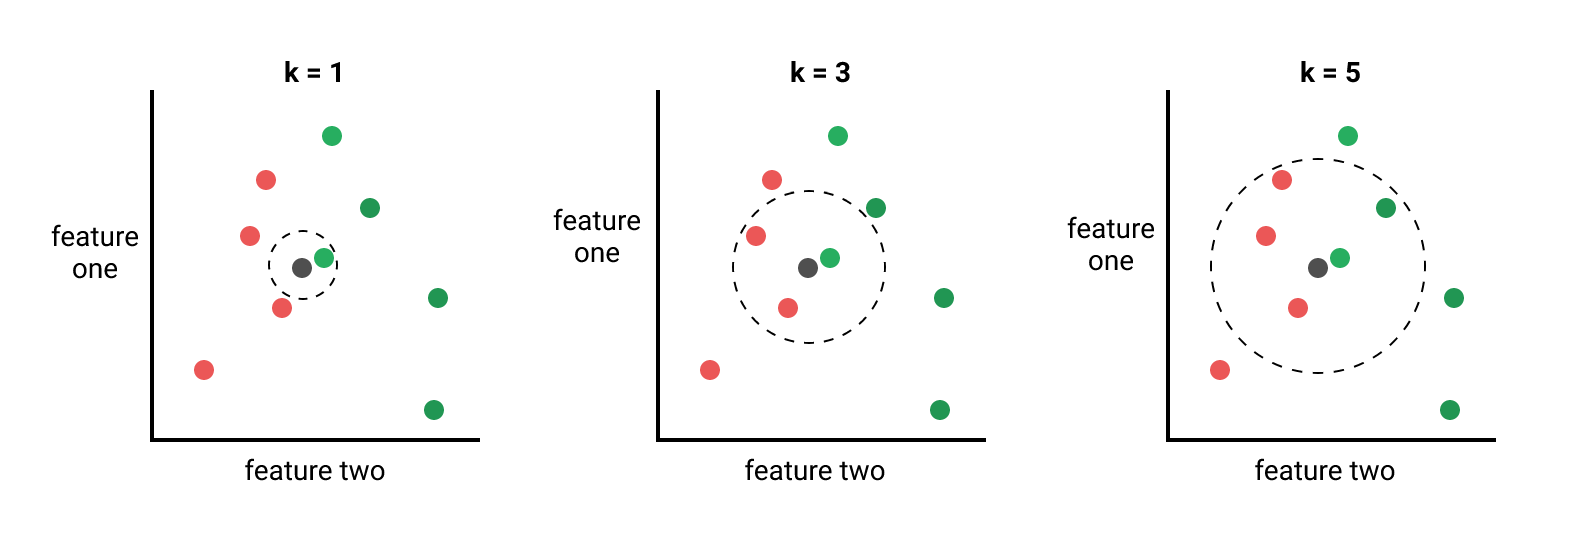

- In the first plot, the value of k is 1. The green dot is therefore the closet neighbor to the gray dot, making the prediction green.
- In the second plot, the value of k is 3. The closest 3 neighbors to our gray dot are used (2 red vs 1 green), making the prediction red.
- In the third plot, the value of k is 5. The closest 5 neighbors to our gray dot are used (3 red vs 2 green), making the prediction red.

Scikit-learn has a class that makes it easy to use k-nearest neighbors to make predictions, `neighbors.KNeighborsClassifier`.

Below, we will:

- Instantiate a `neighbors.KNeighborsClassifier` object, setting the `n_neighbors` argument to `1`.
- Use the `model_selection.cross_val_score()` function to train and test a model assigning the result to `scores`, using:
 - The `KNeighborsClassifier` object you just created.
 - `all_X` and `all_y` as the the `X` and `y` parameters.
 - `10` folds.
- Calculate the mean of scores and assign the result to `accuracy_knn`.

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

scores = cross_val_score(knn, all_X, all_y, cv=10)
accuracy_knn = scores.mean()
print(scores)
print(accuracy_knn)

[0.78888889 0.71910112 0.73033708 0.7752809  0.83146067 0.83146067
 0.78651685 0.76404494 0.78651685 0.82022472]
0.7833832709113608


### Tuning with Hyperparameter Optimization

The k-nearest neighbors model we trained above had an accuracy score of 78.6%, worse than our baseline score of 82.4%. 

Besides pure model selection, we can vary the settings of each model— for instance the value of `k` in our k-nearest neighbors model. This is called **hyperparameter optimization**.

We can use a loop and Python's inbuilt `range()` class to iterate through different values for `k` and calculate the accuracy score for each different value. We will only want to test odd values for k to avoid ties, where both 'survived' and 'died' outcomes would have the same number of neighbors.

We will use this technique to calculate the accuracy of our model for values of `k` from `1-49`, storing the results in a dictionary.

To make the results easier to understand, we'll finish by plotting the scores. We will write a function `plot_dict()` for plotting results easily.

In [52]:
def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

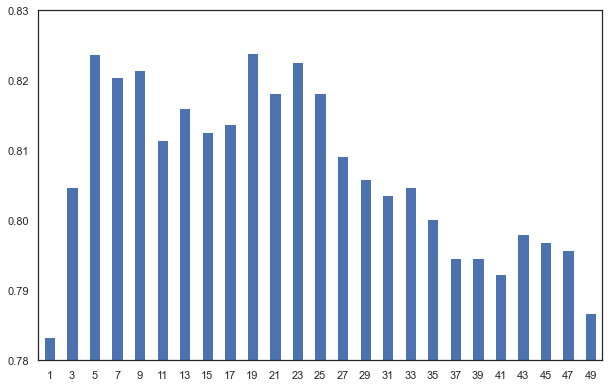

In [53]:
# Calculate mean cross validation accuracy for odd values of k up to 49, and cv = 10
knn_scores = dict()
for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)

    scores = cross_val_score(knn, all_X, all_y, cv=10)
    accuracy_knn = scores.mean()
    knn_scores[k] = accuracy_knn

plot_dict(knn_scores)

### Automating Hyperparameter Optimization with Grid Search

Looking at our plot from the previous screen we can see that a k value of 19 gave us our best score, and checking the `knn_scores` dictionary we can see that the score was 82.4%, identical to our baseline.

The technique we just used is called **grid search** - we train a number of models across a 'grid' of values and then searched for the model that gave us the highest accuracy.

Scikit-learn has a class to perform grid search, `model_selection.GridSearchCV()`. The `'CV'` in the name indicates that we're performing both grid search and cross validation at the same time.

By creating a dictionary of parameters and possible values and passing it to the `GridSearchCV` object we can automate the process. Here's what the code from the previous screen would look like, when implemented using the `GridSearchCV` class. We can then print the `GridSearchCV.best_params_` and `GridSearchCV.best_score_` attributes to retrieve the parameters of the best-performing model, and the score it achieved.

In [54]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

hyperparameters = {
    "n_neighbors": range(1,50,2)
}
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 19}
0.8238576779026218


We can also use GridSearchCV to try combinations of different hyperparameters. For example, if we wanted to test values of `"ball_tree"`, `"kd_tree"`, and "`brute"` for the algorithm parameter and values of `1`, `3`, and `5` for the `n_neighbors`  parameter. `GridSearchCV` would train and test `9` models (`3` for the first hyperparameter times `3` for the second hyperparameter), shown in the diagram below.

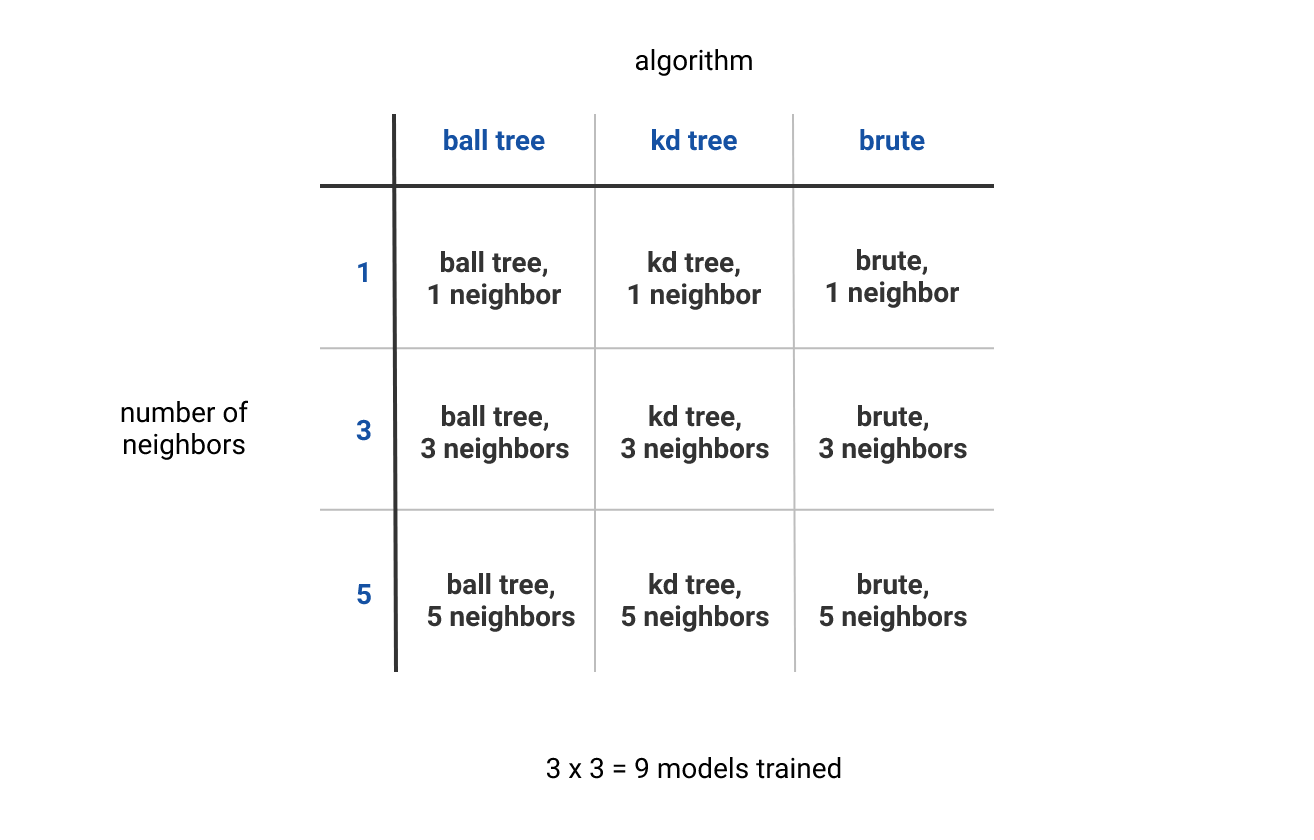

We will use `GridSearchCV` to turbo-charge our search for the best performing parameters for our model, by testing `226` combinations of three different hyperparameters. List of k-neighbors hyperparameters can be found in [KNeighborsClassifier() documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=k%20neighbors#sklearn.neighbors.KNeighborsClassifier)

Below, we will:

- Instantiate a `KNeighborsClassifier` object.
- Instantiate a `GridSearchCV` object, using:
- The `KNeighborsClassifier` object you just created as the first (unnamed) argument.
- The hyperparameters dictionary for the `param_grid`.
- A cv of `10`.
- Fit the `GridSearchCV` object using `all_X` and `all_y`.
- Assign the parameters of the best performing model to `best_params`.
- Assign the score of the best performing model to `best_score`.

In [59]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute', 'ball_tree', 'kd_tree'],
    "p": [1,2]
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

print(grid.best_params_)
print(grid.best_score_)

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.8293882646691635


### Submitting K-Nearest Neighbour Predictions to Kaggle

We can manually specify our best KNN model as:
```
best_knn = KNeighborsClassifier(p=1,algorithm='brute',n_neighbors=5,
                     weights='uniform')
                     
```                     
However, instead, we can just use the `GridSearchCV.best_estimator_` attribute to retrieve a trained model with the best-performing hyperparameters. 

In [60]:
# holdout_no_id = holdout.drop(['PassengerId'],axis=1)
# best_knn = grid.best_estimator_
# holdout_predictions_knn = best_knn.predict(holdout_no_id)

# holdout_ids = holdout["PassengerId"]
# submission_df_knn = {"PassengerId": holdout_ids,
#                  "Survived": holdout_predictions_knn}
# submission_knn = pd.DataFrame(submission_df_knn)

# submission_knn.to_csv("submission_knn_1.csv",index=False)

### Random Forests
With above submission our score has dropped from `77.991%` to `75.6%`. We willl now try another algorithm called **random forests** (We already did but let us change hyperparameters this time). Random forests is a specific type of decision tree algorithm. Decision tree algorithms attempt to build the most efficient decision tree based on the training data, and then use that tree to make future predictions. 

Below, we will instantiate a RandomForestClassifier object at default settings and measure accuracy.

In [61]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1)
scores = cross_val_score(clf, all_X, all_y, cv=10)
accuracy_rf = scores.mean()
print(scores)
print(accuracy_rf)

[0.83333333 0.82022472 0.73033708 0.87640449 0.87640449 0.83146067
 0.7752809  0.7752809  0.84269663 0.84269663]
0.8204119850187267


### Tuning Random Forest Model

We can use a number of hyperparameters to tune the model and then grid search for the best model. The best way to see a list of available hyperparameters is by checking the documentation for the classifier— in this case, the documentation for [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). We will use grid search to test out combinations of the following hyperparameters:

`criterion`: "entropy" or "gini"

`max_depth`: 5 or 10

`max_features`: "log2" or "sqrt"

`min_samples_leaf`: 1 or 5

`min_samples_split`: 3 or 5

`n_estimators`: 6 or 9 or 12 or 18

In [64]:
hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9, 12, 18]
}

clf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_params)
print(best_score)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}
0.838414481897628


We will now train our best model above on the holdout data and create a submission file to see how it performs on the Kaggle leaderboard. 

In [66]:
best_rf = grid.best_estimator_
holdout_predictions_rf = best_rf.predict(holdout_no_id)

holdout_ids = holdout["PassengerId"]
submission_df_rf = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions_rf}
submission_rf = pd.DataFrame(submission_df_rf)

submission_rf.to_csv("submission_rf_5.csv",index=False)

### Results
Above submissions gives a result of 76.794% which is less than our best score that we have already achieved i.e. 77.99%